mounting google drive (you should have gbm data file uploaded in the drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


setting random seed so that the output doesn't change when rerunning the model

In [2]:
import random
import numpy as np
import torch

# Set random seeds for reproducibility
random_seed = 123
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import sys

the path to the GBM file in google drive

In [4]:
sys.path.insert(0,"/content/drive/MyDrive/23_GBM_AP1")

In [5]:
 ! pip install scanpy
 ! pip install torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=2d17a47c88bf67f9a74b465a15e00e309baf7bab8ee3d573bd5cf144202e878f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=0ee09fbbcbfb4e24c710685972cc6951a359a3ab354831453eae78a6626779c6
  Stored in directory: /root/.cache/pip/wheels/6a/a

import necessary dependencies

In [6]:
import torch
from vega_model import VEGA
from utils import *
from learning_utils import *
import scanpy as sc
from scipy import sparse
from sklearn import preprocessing
import numpy as np
import itertools
import argparse
import os
import pandas as pd

In [7]:
data_path= '/content/drive/MyDrive/23_GBM_AP1/data/'

finding the data file to be trained


In [8]:
train_file_list=os.listdir(data_path)
train_file_list=[i for i in train_file_list if '.h5ad' in i]

In [9]:
train_file_list

['GBM_AP1_treatment.h5ad']

In [10]:
train_data = sc.read(data_path +train_file_list[0])

/usr/local/lib/python3.10/dist-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


this is our AnnData

In [11]:
print(train_data)


AnnData object with n_obs × n_vars = 3593 × 10000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'primary.predict', 'secondary.predict', 'label'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_UMAP', 'X_pca'
    varm: 'PCs'
    obsp: 'distances'


In [12]:
pathway_path= '/content/drive/MyDrive/23_GBM_AP1/pathway/'

In [13]:
pathway_file_list=os.listdir(pathway_path)
pathway_file_list=[i for i in pathway_file_list if '.gmt' in i]

In [14]:
pathway_file_list

['c2.cp.reactome.v7.5.1.symbols.gmt',
 'GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt']

In [15]:
from collections import OrderedDict

pathway_dict_combined = OrderedDict()  # Convert to an OrderedDict
for pathway_file in pathway_file_list:
    pathway_dict_combined.update(read_gmt(pathway_path + pathway_file, min_g=0, max_g=1000))


In [16]:
print(train_data.shape, flush=True)

(3593, 10000)


In [17]:
pathway_mask = create_pathway_mask(list(train_data.var.index), pathway_dict_combined, add_missing=1, fully_connected=True)

In [18]:
print(train_data.X.shape, flush=True)
print(pathway_mask.shape, flush=True)

(3593, 10000)
(10000, 2915)


In [19]:
path_way_ind = []
for i in range(pathway_mask.shape[0]):
    path_way_ind.append(np.argmax(pathway_mask[i, :]))

In [20]:
print(path_way_ind)

[2914, 2914, 2914, 2914, 2914, 155, 5, 2914, 2914, 2914, 77, 2534, 190, 354, 2914, 2914, 1, 2914, 2914, 289, 1519, 329, 1156, 596, 155, 1811, 2914, 596, 76, 1632, 2914, 2914, 1796, 1629, 2914, 980, 1059, 1753, 2914, 1675, 77, 1611, 76, 2914, 1614, 2, 1144, 1239, 2914, 212, 2914, 2914, 359, 77, 5, 350, 520, 2914, 402, 115, 76, 1711, 1778, 1079, 2914, 2914, 2914, 2914, 349, 1079, 1, 580, 2914, 2914, 2914, 2914, 138, 626, 2914, 2914, 2914, 2914, 2914, 2914, 2914, 1937, 2914, 2914, 561, 561, 561, 2914, 2914, 2914, 2914, 2914, 118, 2914, 2071, 154, 31, 1691, 49, 596, 2914, 177, 77, 1006, 2914, 2914, 521, 2914, 2, 2914, 1637, 2914, 211, 2914, 150, 2914, 596, 1323, 1724, 634, 1875, 2914, 1621, 343, 1151, 1146, 1146, 2914, 374, 2914, 2914, 1615, 1768, 61, 634, 1701, 979, 1745, 1680, 1378, 1634, 31, 2914, 2914, 176, 374, 1940, 212, 2914, 2914, 2914, 1741, 2914, 1014, 76, 594, 1627, 167, 1703, 2914, 167, 2914, 1086, 1640, 76, 33, 104, 2914, 1722, 2914, 182, 1143, 596, 107, 2914, 1875, 2914, 1266

In [21]:
print(pathway_mask.shape, flush=True)

(10000, 2915)


In [22]:
labels = train_data.obs['label'].values
le = preprocessing.LabelEncoder()
le.fit(labels)
y = torch.Tensor(le.transform(labels))

In [23]:
train_ds = torch.Tensor(train_data.X)
train_ds = UnsupervisedDataset(train_ds,y)

training the model

In [24]:
LR = 1e-4
N_EPOCHS=10
p_drop = 0.5
dir_name='/content/drive/MyDrive/23_GBM_AP1/save_model'
model_prefix=pathway_file_list[0].split('.gmt')[0].split('.')[0].split('_')[0]+'_GBM' # change the number of pathway_file_list , the number should be the same with you choose before

In [25]:
kfold = KFoldTorch(cv=2, n_epochs=N_EPOCHS, lr=LR, train_p=10, test_p=10, num_workers=0, save_all=True, save_best=False, path_dir=dir_name, model_prefix='go__all')
dict_params = {'pathway_mask':pathway_mask, 'beta':0.0001, 'dropout':p_drop, 'path_model':None, 'device':'cpu', 'positive_decoder':True}
kfold.train_kfold(VEGA, dict_params, train_ds, batch_size=700)
np.save(dir_name+'5CV_vega_organoid.npy', kfold.cv_res_dict)



Model(s) will be saved at /content/drive/MyDrive/23_GBM_AP1/save_model/ using go__all as prefix
0.5
Constraining decoder to positive weights
cpu
Training fold 0
[Epoch 1] | loss: 8837.642 | test_loss: 8857.687 |
[Epoch 2] | loss: 8853.604 | test_loss: 8870.810 |
[Epoch 3] | loss: 8839.705 | test_loss: 8839.236 |
[Epoch 4] | loss: 8805.151 | test_loss: 8816.648 |
[Epoch 5] | loss: 8818.780 | test_loss: 8848.174 |
[Epoch 6] | loss: 8822.711 | test_loss: 8834.371 |
[Epoch 7] | loss: 8792.250 | test_loss: 8845.070 |
[Epoch 8] | loss: 8809.730 | test_loss: 8821.725 |
[Epoch 9] | loss: 8806.160 | test_loss: 8861.354 |
[Epoch 10] | loss: 8817.208 | test_loss: 8859.689 |
Saving model at /content/drive/MyDrive/23_GBM_AP1/save_model/go__allfold_0.pt
0.5
Constraining decoder to positive weights
cpu
Training fold 1
[Epoch 1] | loss: 8832.057 | test_loss: 8829.041 |
[Epoch 2] | loss: 8845.256 | test_loss: 8807.930 |
[Epoch 3] | loss: 8874.922 | test_loss: 8808.525 |
[Epoch 4] | loss: 8902.179 | tes

In [26]:
model = VEGA(pathway_mask, positive_decoder=False)
# Load the trained model weights
model.load_state_dict(torch.load('/content/drive/MyDrive/23_GBM_AP1/save_model/go__allfold_0.pt'))
# Set the model to evaluation mode
model.eval()
print(model)

0.2
VEGA(
  (encoder): Sequential(
    (0): Linear(in_features=10000, out_features=800, bias=True)
    (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=800, out_features=800, bias=True)
    (5): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (mean): Sequential(
    (0): Linear(in_features=800, out_features=2915, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (logvar): Sequential(
    (0): Linear(in_features=800, out_features=2915, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  )
  (decoder): CustomizedLinear(input_features=2915, output_features=10000, bias=True)
)


In [27]:
torch.save(model.state_dict(), '/content/drive/MyDrive/23_GBM_AP1/save_model/go__allfold_0.pt')


**UMAP representing control and treatment data**

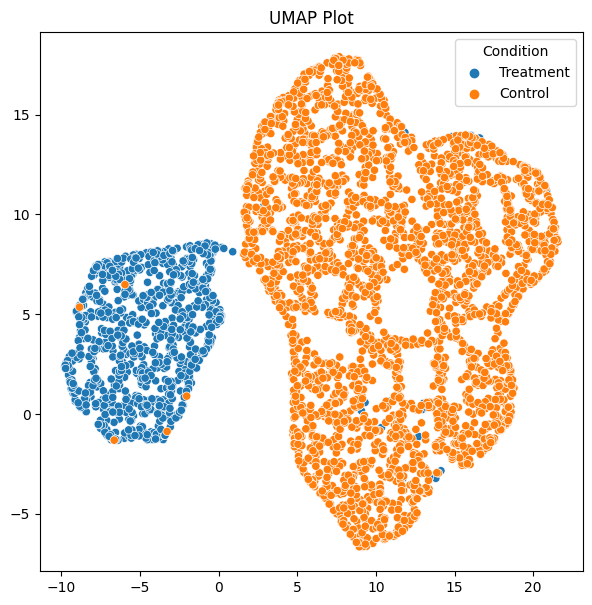

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

# Store the chosen latent representation in the 'obsm' attribute
train_data.obsm['X_latent'] = train_data.obsm['X_UMAP']  # or X_pca or X_umap

# Perform UMAP computation using the chosen latent representation
sc.pp.neighbors(train_data, use_rep='X_latent', n_neighbors=15)
sc.tl.umap(train_data, min_dist=0.5, random_state=42)

# Store UMAP coordinates in the 'uns' attribute
train_data.uns['X_umap'] = train_data.obsm['X_umap']

umap_df = pd.DataFrame({'UMAP-1': train_data.obsm['X_umap'][:, 0],
                        'UMAP-2': train_data.obsm['X_umap'][:, 1],
                        'Cell Type': train_data.obs['label'],
                        'Condition': train_data.obs['label']})

fig, ax = plt.subplots(figsize=[7, 7])
sns.scatterplot(data=umap_df, x='UMAP-1', y='UMAP-2', hue='Condition', ax=ax)

plt.xlabel('')
plt.ylabel('')
plt.title('UMAP Plot')
plt.show()


**making our pathway by cell matrix**

In [29]:
import torch

# Assuming you have the `pathway_mask`, `train_ds`, and `train_data` defined from the previous code

# Recreate the VEGA model instance with the same configuration
from vega_model import VEGA
model = VEGA(pathway_mask, positive_decoder=False)

# Load the trained model state_dict
model.load_state_dict(torch.load('/content/drive/MyDrive/23_GBM_AP1/save_model/go__allfold_0.pt'))

# Set the model to evaluation mode
model.eval()

# Get cell and pathway names
cell_names = train_data.obs.index.tolist()
pathway_names = list(pathway_dict_combined.keys())

# Create an empty matrix to store the pathway by cell matrix
pathway_by_cell_matrix = np.zeros((len(pathway_names), len(cell_names)))

# Loop through each cell and compute its pathway activations
for i, cell_name in enumerate(cell_names):
    # Get the input data for the current cell
    input_data = train_ds[i]

    # Reshape the input data to have a batch dimension
    input_data = input_data.view(1, -1)  # Assuming each cell data is a 1D tensor

    # Forward pass through the model to get the pathway activations
    with torch.no_grad():
        _, _, pathway_activations = model(input_data)

    # Ensure that the pathway activations match the number of pathways
    pathway_activations = pathway_activations.view(-1)[:len(pathway_names)]

    # Store the pathway activations in the pathway by cell matrix
    pathway_by_cell_matrix[:, i] = pathway_activations.numpy()

# Create a DataFrame with pathway names as rows and cell names as columns
pathway_by_cell_df = pd.DataFrame(pathway_by_cell_matrix, index=pathway_names, columns=cell_names)

# Now you have the pathway by cell matrix as a DataFrame with pathway names as rows and cell names as columns
print(pathway_by_cell_df)


0.2
                                                    T5224_10uM_3days_AAACCCACAACTGATC  \
REACTOME_INTERLEUKIN_6_SIGNALING                                            -0.233995   
REACTOME_APOPTOSIS                                                          -0.109295   
REACTOME_HEMOSTASIS                                                          0.006861   
REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS                                     0.044291   
REACTOME_MAPK3_ERK1_ACTIVATION                                               0.220624   
...                                                                               ...   
MF_organic_hydroxy_compound_transmembrane_trans...                          -0.172310   
MF_sulfur_compound_binding                                                  -0.568582   
MF_sulfur_compound_transmembrane_transporter_ac...                          -0.049042   
MF_protein_tyrosine_kinase_binding                                          -0.421322   
MF_promoter_speci

In [30]:
# Assuming you have already computed the pathway_by_cell_df DataFrame as shown in the previous code
import pandas as pd

# Replace 'pathway_by_cell_matrix.tsv' with your desired file name
output_file = '/content/drive/MyDrive/23_GBM_AP1/pathway_by_cell_matrix.tsv'

# Save the pathway_by_cell_df DataFrame as a TSV file
pathway_by_cell_df.to_csv(output_file, sep='\t')


In [31]:
pathway_by_cell_df

T5224_10uM_3days_AAACCCACAACTGATC  \
REACTOME_INTERLEUKIN_6_SIGNALING                                            -0.233995   
REACTOME_APOPTOSIS                                                          -0.109295   
REACTOME_HEMOSTASIS                                                          0.006861   
REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS                                     0.044291   
REACTOME_MAPK3_ERK1_ACTIVATION                                               0.220624   
...                                                                               ...   
MF_organic_hydroxy_compound_transmembrane_trans...                          -0.172310   
MF_sulfur_compound_binding                                                  -0.568582   
MF_sulfur_compound_transmembrane_transporter_ac...                          -0.049042   
MF_protein_tyrosine_kinase_binding                                          -0.421322   
MF_promoter_specific_chromatin_binding                                      -0.288064   

                                                    T5224_10uM_3days_AAACGCTGTCGCATTA  \
REACTOME_INTERLEUKIN_6_SIGNALING                                            -0.152927   
REACTOME_APOPTOSIS                                                          -0.155877   
REACTOME_HEMOSTASIS                                                         -0.009651   
REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS                                    -0.053491   
REACTOME_MAPK3_ERK1_ACTIVATION                                              -0.019299   
...                                                                               ...   
MF_organic_hydroxy_compound_transmembrane_trans...                          -0.253170   
MF_sulfur_compound_binding                                                  -0.117668   
MF_sulfur_compound_transmembrane_transporter_ac...                           0.023335   
MF_protein_tyrosine_kinase_binding                                          -0.078392   
MF_promoter_specific_chromatin_binding                                       0.100561   

                                                    T5224_10uM_3days_AAACGCTTCCCTTCCC  \
REACTOME_INTERLEUKIN_6_SIGNALING                                            -0.511513   
REACTOME_APOPTOSIS                                                          -0.116617   
REACTOME_HEMOSTASIS                                                         -0.007983   
REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS                                    -0.243846   
REACTOME_MAPK3_ERK1_ACTIVATION                                              -0.236422   
...                                                                               ...   
MF_organic_hydroxy_compound_transmembrane_trans...                          -0.148626   
MF_sulfur_compound_binding                                                   0.067720   
MF_sulfur_compound_transmembrane_transporter_ac...                          -0.111145   
MF_protein_tyrosine_kinase_binding                                          -0.279687   
MF_promoter_specific_chromatin_binding                                      -0.338930   

                                                    T5224_10uM_3days_AAAGAACCACCTCGTT  \
REACTOME_INTERLEUKIN_6_SIGNALING                                            -0.381950   
REACTOME_APOPTOSIS                                                          -0.276732   
REACTOME_HEMOSTASIS                                                         -0.423288   
REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS                                    -0.262994   
REACTOME_MAPK3_ERK1_ACTIVATION                                              -0.205392   
...                                                                               ...   
MF_organic_hydroxy_compound_transmembrane_trans...                           0.069819   
MF_sulfur_compound_binding                                                  -0.183544   
MF_sulfur_compound_transmembrane_transporter

In [32]:
treatment_labels = ['Treatment']
treatment_data = train_data[train_data.obs['label'].isin(treatment_labels)]
control_labels = ['Control']
control_data = train_data[train_data.obs['label'].isin(control_labels)]
treatment_indices = [train_data.obs_names.get_loc(index) for index in treatment_data.obs_names]
control_indices = [train_data.obs_names.get_loc(index) for index in control_data.obs_names]

**wilcoxon test to get the p-values and log 2 fold changes**

In [33]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
def wilcoxon_test(matrix, group1, group2):
    """
    Perform Wilcoxon rank-sum test between two groups in the matrix.
    Parameters:
        matrix (np.ndarray): Gene-by-cells matrix with genes as rows and cells as columns.
        group1 (list or np.ndarray): Indices or boolean mask for the first group of cells.
        group2 (list or np.ndarray): Indices or boolean mask for the second group of cells.
    Returns:
        (np.ndarray, np.ndarray): Array of p-values and array of log2 fold changes for each gene.
    """
    group1_cells = matrix[:, group1]
    group2_cells = matrix[:, group2]
    p_values = np.zeros(matrix.shape[0])
    log2_fold_changes = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        _, p_value = stats.ranksums(group1_cells[i], group2_cells[i])
        p_values[i] = p_value
        mean_group1 = np.mean(group1_cells[i])
        mean_group2 = np.mean(group2_cells[i])
        #print(mean_group1, mean_group2)
        epsilon = 1e-10  # Small constant to avoid division by zero
        log2_fold_changes[i] = np.log2(((np.mean(group2_cells[i])) / (np.mean(group1_cells[i]))))

        #log2_fold_changes[i] = np.log2(mean_group2 / mean_group1)
    return p_values, log2_fold_changes

pathway_by_cell_array = pathway_by_cell_df.values

# Call the wilcoxon_test function with your data
p_values, log2_fold_changes = wilcoxon_test(pathway_by_cell_array, treatment_indices, control_indices)

results_df = pd.DataFrame({
    'Pathway': pathway_by_cell_df.index,  # Assuming 'pathway_by_cell_df' has pathway names as index
    'P-Value': p_values,
    'Log2 Fold Change': log2_fold_changes
})

# Print the DataFrame (optional)
print(results_df)

# Save the DataFrame to a CSV file (optional)
results_df.to_csv('wilcoxon_results.csv', index=False)

<ipython-input-33-49676c1a0a5c>:25: RuntimeWarning: invalid value encountered in log2
  log2_fold_changes[i] = np.log2(((np.mean(group2_cells[i])) / (np.mean(group1_cells[i]))))


                                                Pathway       P-Value  \
0                      REACTOME_INTERLEUKIN_6_SIGNALING  6.677188e-29   
1                                    REACTOME_APOPTOSIS  1.499515e-01   
2                                   REACTOME_HEMOSTASIS  1.870981e-11   
3              REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS  7.403270e-01   
4                        REACTOME_MAPK3_ERK1_ACTIVATION  3.815597e-07   
...                                                 ...           ...   
2909  MF_organic_hydroxy_compound_transmembrane_tran...  3.188374e-04   
2910                         MF_sulfur_compound_binding  6.114455e-29   
2911  MF_sulfur_compound_transmembrane_transporter_a...  2.946136e-08   
2912                 MF_protein_tyrosine_kinase_binding  1.287033e-37   
2913             MF_promoter_specific_chromatin_binding  1.216916e-01   

      Log2 Fold Change  
0            -0.448321  
1             0.078053  
2            -0.732044  
3             0.025108 

In [35]:
results_df

Pathway       P-Value  \
0                      REACTOME_INTERLEUKIN_6_SIGNALING  6.677188e-29   
1                                    REACTOME_APOPTOSIS  1.499515e-01   
2                                   REACTOME_HEMOSTASIS  1.870981e-11   
3              REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS  7.403270e-01   
4                        REACTOME_MAPK3_ERK1_ACTIVATION  3.815597e-07   
...                                                 ...           ...   
2909  MF_organic_hydroxy_compound_transmembrane_tran...  3.188374e-04   
2910                         MF_sulfur_compound_binding  6.114455e-29   
2911  MF_sulfur_compound_transmembrane_transporter_a...  2.946136e-08   
2912                 MF_protein_tyrosine_kinase_binding  1.287033e-37   
2913             MF_promoter_specific_chromatin_binding  1.216916e-01   

      Log2 Fold Change  
0            -0.448321  
1             0.078053  
2            -0.732044  
3             0.025108  
4            -1.115328  
...                ...  
2909         -0.203165  
2910          0.608661  
2911         -1.390971  
2912          0.491944  
2913         -0.059299  

[2914 rows x 3 columns]

In [37]:
pathway_by_cell_array = pathway_by_cell_df.values
pathway_names = pathway_by_cell_df.index

# Assuming treatment_indices and control_indices are valid row indices
# of the pathway_by_cell_array, make sure they are within bounds.
treatment_indices = [index for index in treatment_indices if index < pathway_by_cell_array.shape[0]]
control_indices = [index for index in control_indices if index < pathway_by_cell_array.shape[0]]

# Call the wilcoxon_test function with your data
p_values, log2_fold_changes = wilcoxon_test(pathway_by_cell_array, treatment_indices, control_indices)

# Sort the p-values and log2 fold changes in descending order
sorted_indices = np.argsort(p_values)
sorted_p_values = p_values[sorted_indices]
sorted_log2_fold_changes = log2_fold_changes[sorted_indices]

# Define the number of top pathways you want to display (e.g., top 10)
top_pathways_to_display = 10
top_indices = sorted_indices[:top_pathways_to_display]

# Retrieve the pathway names for the top pathways
top_pathway_names = pathway_names[top_indices]

# Print the top pathways along with their p-values and log2 fold changes
print("Top Pathways:")
print("Pathway Name\t\t\tP-value\t\tLog2 Fold Change")
for name, p_value, log2_fc in zip(top_pathway_names, sorted_p_values[:top_pathways_to_display], sorted_log2_fold_changes[:top_pathways_to_display]):
    print(f"{name}\t\t{p_value}\t\t{log2_fc}")


<ipython-input-34-49676c1a0a5c>:25: RuntimeWarning: invalid value encountered in log2
  log2_fold_changes[i] = np.log2(((np.mean(group2_cells[i])) / (np.mean(group1_cells[i]))))


Top Pathways:
Pathway Name			P-value		Log2 Fold Change
REACTOME_EGFR_DOWNREGULATION		2.475609268843773e-99		1.078593757042152
BP_aminoglycan_metabolic_process		2.557120145804158e-98		1.3645608227639225
MF_ubiquitin_like_protein_ligase_binding		4.843817955927063e-95		0.716206942844025
REACTOME_ACTIVATION_OF_C3_AND_C5		3.1655610066071114e-86		nan
REACTOME_GOLGI_ASSOCIATED_VESICLE_BIOGENESIS		3.507996584344161e-83		1.6736279662905476
REACTOME_MITOCHONDRIAL_BIOGENESIS		1.2721063824369529e-82		nan
REACTOME_GLYCOSAMINOGLYCAN_METABOLISM		3.3902514344264884e-79		1.411105908676753
BP_regulation_of_binding		1.2635378639126543e-78		0.8481992136597443
REACTOME_WAX_AND_PLASMALOGEN_BIOSYNTHESIS		6.450158096867409e-78		-2.1227938510054267
REACTOME_SULFUR_AMINO_ACID_METABOLISM		8.83470108367819e-77		nan


**volcano plot**

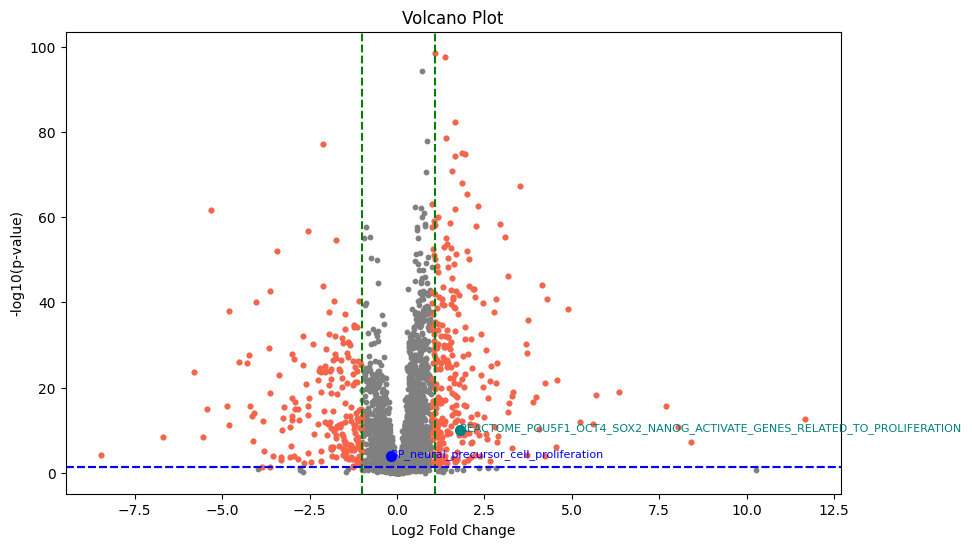

In [38]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

def volcano_plot(p_values, log2_fold_changes, pathway_names, significance_threshold=0.05, highlighted_pathways=None):
    """
    Create a volcano plot from p-values and log2 fold changes.
    Parameters:
        p_values (np.ndarray): Array of p-values for each gene.
        log2_fold_changes (np.ndarray): Array of log2 fold changes for each gene.
        pathway_names (list): List of pathway names for each gene.
        significance_threshold (float, optional): Threshold for determining significant genes.
        highlighted_pathways (list, optional): List of pathway names to highlight on the plot.
    Returns:
        None (plots the volcano plot using matplotlib).
    """
    significant_genes = np.abs(log2_fold_changes) > np.log2(2)  # Fold change of 2x or more
    significant_genes &= p_values < significance_threshold

    plt.figure(figsize=(10, 6))
    plt.scatter(log2_fold_changes, -np.log10(p_values), s=10, color='grey', label='Non-Significant')
    plt.scatter(log2_fold_changes[significant_genes], -np.log10(p_values[significant_genes]), s=10, color='tomato', label='Significant')
    plt.axhline(-np.log10(significance_threshold), color='blue', linestyle='dashed', label='Significance threshold')
    if highlighted_pathways:
        # Find the indices of the pathways to highlight
        highlighted_indices = [i for i, name in enumerate(pathway_names) if name in highlighted_pathways]

        # Set colors for the highlighted pathways
        colors = ['teal', 'blue']  # Match the colors with the order of highlighted_pathways

        # Plot the highlighted pathways with different colors
        for i, idx in enumerate(highlighted_indices):
            plt.scatter(log2_fold_changes[idx], -np.log10(p_values[idx]), s=50, color=colors[i])
            # Add text labels for highlighted pathways
            plt.text(log2_fold_changes[idx], -np.log10(p_values[idx]), highlighted_pathways[i], fontsize=8, color=colors[i])

    # Adding dashed vertical green lines between significant and non-significant data
    median_log2fc_significant = np.median(log2_fold_changes[significant_genes])
    plt.axvline(median_log2fc_significant, color='green', linestyle='dashed')
    plt.axvline(-1, color='green', linestyle='dashed')
    plt.axhline(-np.log10(significance_threshold), color='blue', linestyle='dashed', label='Significance threshold')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-log10(p-value)')
    plt.title('Volcano Plot')
    plt.show()

# Example usage:
# Assuming you have a numpy array called 'gene_by_cells_matrix' and two lists of indices for groups 'group1_indices' and 'group2_indices'.
# Also, assuming you have a list of pathway names 'pathway_names' for each gene.

# You can specify the pathways you want to highlight as a list in the 'highlighted_pathways' parameter.
highlighted_pathways = ['REACTOME_POU5F1_OCT4_SOX2_NANOG_ACTIVATE_GENES_RELATED_TO_PROLIFERATION', 'BP_neural_precursor_cell_proliferation']
volcano_plot(p_values, log2_fold_changes, pathway_names, highlighted_pathways=highlighted_pathways)


In [39]:
import scanpy as sc
import matplotlib.pyplot as plt

treatment_labels = ['Treatment']
treatment_data = train_data[train_data.obs['label'].isin(treatment_labels)]

control_labels = ['Control']
control_data = train_data[train_data.obs['label'].isin(control_labels)]

results = model.bayesian_diff_exp(treatment_data, control_data)
bayes_result = pd.DataFrame(results)

In [40]:
bayes_result

p_h1   p_h2  bayes_factor       mad
0     0.514  0.486      0.056015  0.022405
1     0.494  0.506     -0.024001  0.012044
2     0.535  0.465      0.140229  0.091316
3     0.477  0.523     -0.092065  0.125959
4     0.473  0.527     -0.108105  0.064157
...     ...    ...           ...       ...
2910  0.482  0.518     -0.072031  0.047797
2911  0.492  0.508     -0.032003  0.031747
2912  0.484  0.516     -0.064022  0.002040
2913  0.496  0.504     -0.016000  0.016403
2914  0.701  0.299      0.852064  1.042341

[2915 rows x 4 columns]

**UMAP for 2 pathways showing change in intensity of pathway activity**

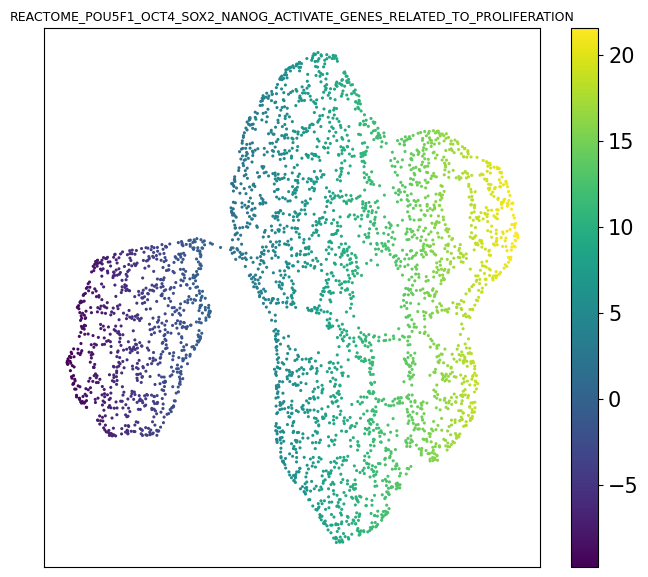

In [41]:
train_data.obs['REACTOME_POU5F1_OCT4_SOX2_NANOG_ACTIVATE_GENES_RELATED_TO_PROLIFERATION'] = train_data.obsm['X_umap'][:, 0]

fig, ax = plt.subplots(figsize=[8, 7])
sct = ax.scatter(
    train_data.obsm['X_umap'][:, 0], train_data.obsm['X_umap'][:, 1],
    alpha=1, linewidths=0, c=train_data.obs['REACTOME_POU5F1_OCT4_SOX2_NANOG_ACTIVATE_GENES_RELATED_TO_PROLIFERATION'],
    marker='o', s=5, cmap='viridis', rasterized=True
)
cbar = fig.colorbar(sct, ax=ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
ax.set_title('REACTOME_POU5F1_OCT4_SOX2_NANOG_ACTIVATE_GENES_RELATED_TO_PROLIFERATION', fontsize=9)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig('/content/drive/MyDrive/23_GBM_AP1/save_model' +'umap_ifn.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()



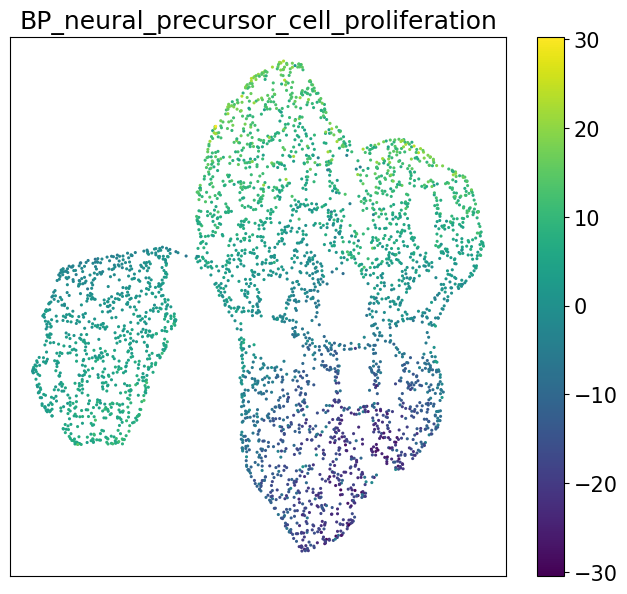

In [42]:
train_data.obs['BP_neural_precursor_cell_proliferation'] = train_data.obsm['X_pca'][:, 0]

fig, ax = plt.subplots(figsize=[8, 7])
sct = ax.scatter(
    train_data.obsm['X_umap'][:, 0], train_data.obsm['X_umap'][:, 1],
    alpha=1, linewidths=0, c=train_data.obs['BP_neural_precursor_cell_proliferation'],
    marker='o', s=5, cmap='viridis', rasterized=True
)
cbar = fig.colorbar(sct, ax=ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(15)
ax.set_title('BP_neural_precursor_cell_proliferation', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.savefig('/content/drive/MyDrive/23_GBM_AP1/save_model' +'umap_ifn.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


counting the number of active cells in treatment and control

In [43]:
# Calculate the indices of the treatment and control cells in the train_data
treatment_labels = ['Treatment']
treatment_data = train_data[train_data.obs['label'].isin(treatment_labels)]

control_labels = ['Control']
control_data = train_data[train_data.obs['label'].isin(control_labels)]
treatment_indices = [train_data.obs_names.get_loc(index) for index in treatment_data.obs_names]
control_indices = [train_data.obs_names.get_loc(index) for index in control_data.obs_names]

# Use the pathway mask to filter pathways for Treatment and Control data
treatment_pathways = pathway_mask[treatment_indices, :].sum(axis=0)
control_pathways = pathway_mask[control_indices, :].sum(axis=0)

# Get the pathway names corresponding to Treatment and Control data
pathway_names = list(pathway_dict_combined.keys())  # Assuming pathway_dict contains the pathway names

# Create a dictionary to store the pathways corresponding to Treatment and Control data
pathways_by_label = {
    'Treatment': {pathway_names[i]: treatment_pathways[i] for i in range(len(pathway_names))},
    'Control': {pathway_names[i]: control_pathways[i] for i in range(len(pathway_names))},
}
matrix_data = []
for pathway in pathway_names:
    control_count = pathways_by_label['Control'].get(pathway, 0)
    treatment_count = pathways_by_label['Treatment'].get(pathway, 0)
    matrix_data.append([pathway, control_count, treatment_count])

# Convert the matrix_data list to a NumPy array
matrix_data = np.array(matrix_data)

# Optionally, convert the matrix_data to a pandas DataFrame for better tabular representation
import pandas as pd
df = pd.DataFrame(matrix_data, columns=['Pathway', 'Control Cells', 'Treatment Cells'])

# Print the DataFrame
print(df)

                                                Pathway Control Cells  \
0                      REACTOME_INTERLEUKIN_6_SIGNALING           1.0   
1                                    REACTOME_APOPTOSIS          18.0   
2                                   REACTOME_HEMOSTASIS          66.0   
3              REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS           5.0   
4                        REACTOME_MAPK3_ERK1_ACTIVATION           1.0   
...                                                 ...           ...   
2909  MF_organic_hydroxy_compound_transmembrane_tran...           2.0   
2910                         MF_sulfur_compound_binding          29.0   
2911  MF_sulfur_compound_transmembrane_transporter_a...           7.0   
2912                 MF_protein_tyrosine_kinase_binding          10.0   
2913             MF_promoter_specific_chromatin_binding           5.0   

     Treatment Cells  
0                1.0  
1                4.0  
2               22.0  
3                1.0  
4       

In [44]:
# Calculate the indices of the treatment and control cells in the train_data
treatment_labels = ['Treatment']
treatment_data = train_data[train_data.obs['label'].isin(treatment_labels)]

control_labels = ['Control']
control_data = train_data[train_data.obs['label'].isin(control_labels)]
treatment_indices = [train_data.obs_names.get_loc(index) for index in treatment_data.obs_names]
control_indices = [train_data.obs_names.get_loc(index) for index in control_data.obs_names]

# Use the pathway mask to filter pathways for Treatment and Control data
treatment_pathways = pathway_mask[treatment_indices, :].sum(axis=0)
control_pathways = pathway_mask[control_indices, :].sum(axis=0)

# Get the pathway names corresponding to Treatment and Control data
pathway_names = list(pathway_dict_combined.keys())  # Assuming pathway_dict contains the pathway names

# Create a dictionary to store the pathways corresponding to Treatment and Control data
pathways_by_label = {
    'Treatment': {pathway_names[i]: treatment_pathways[i] for i in range(len(pathway_names))},
    'Control': {pathway_names[i]: control_pathways[i] for i in range(len(pathway_names))},
}

# Print the pathways corresponding to Treatment data
print("Pathways corresponding to Treatment data:")
for pathway, count in pathways_by_label['Treatment'].items():
    print(f"{pathway}: {count} cells")

# Print the pathways corresponding to Control data
print("\nPathways corresponding to Control data:")
for pathway, count in pathways_by_label['Control'].items():
    print(f"{pathway}: {count} cells.")

import csv

output_file = "pathways_data.tsv"

# Calculate the total cell count for each pathway
pathway_total_counts = {}
for pathway in pathway_names:
    treatment_count = pathways_by_label['Treatment'].get(pathway, 0)
    control_count = pathways_by_label['Control'].get(pathway, 0)
    total_count = treatment_count + control_count
    pathway_total_counts[pathway] = total_count

# Sort pathways based on total cell count in descending order
sorted_pathways = sorted(pathway_total_counts.items(), key=lambda x: x[1], reverse=True)

# Save the pathways data to the TSV file in descending order
with open(output_file, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerow(["Pathway", "Treatment Cells", "Control Cells"])

    for pathway, total_count in sorted_pathways:
        treatment_count = pathways_by_label['Treatment'].get(pathway, 0)
        control_count = pathways_by_label['Control'].get(pathway, 0)
        writer.writerow([pathway, treatment_count, control_count])

print(f"Pathways data saved to {output_file}.")


Streaming output truncated to the last 5000 lines.
REACTOME_REPRESSION_OF_WNT_TARGET_GENES: 0.0 cells
REACTOME_SUMOYLATION_OF_DNA_METHYLATION_PROTEINS: 3.0 cells
REACTOME_SUMOYLATION_OF_IMMUNE_RESPONSE_PROTEINS: 2.0 cells
REACTOME_SIGNALING_BY_WNT_IN_CANCER: 0.0 cells
REACTOME_SIGNALING_BY_CTNNB1_PHOSPHO_SITE_MUTANTS: 0.0 cells
REACTOME_INTERCONVERSION_OF_NUCLEOTIDE_DI_AND_TRIPHOSPHATES: 2.0 cells
REACTOME_PRESYNAPTIC_FUNCTION_OF_KAINATE_RECEPTORS: 0.0 cells
REACTOME_GPCR_LIGAND_BINDING: 14.0 cells
REACTOME_DEFECTIVE_GALNT3_CAUSES_HFTC: 0.0 cells
REACTOME_DEFECTIVE_LFNG_CAUSES_SCDO3: 0.0 cells
REACTOME_DEFECTIVE_C1GALT1C1_CAUSES_TNPS: 0.0 cells
REACTOME_WNT5A_DEPENDENT_INTERNALIZATION_OF_FZD4: 0.0 cells
REACTOME_INTERLEUKIN_3_INTERLEUKIN_5_AND_GM_CSF_SIGNALING: 1.0 cells
REACTOME_WNT5A_DEPENDENT_INTERNALIZATION_OF_FZD2_FZD5_AND_ROR2: 1.0 cells
REACTOME_O_LINKED_GLYCOSYLATION: 4.0 cells
REACTOME_O_GLYCOSYLATION_OF_TSR_DOMAIN_CONTAINING_PROTEINS: 2.0 cells
REACTOME_MITOPHAGY: 0.0 cells
R

printing pathways from both files

In [45]:
# Specify the directory path where the pathway files are located
directory_path = '/content/drive/MyDrive/23_GBM_AP1/pathway'  # Replace with the actual directory path if different

# Specify the pathway file names
pathway_file_list #= ['c2.cp.reactome.v7.5.1.symbols.gmt', 'GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt']

# Iterate over the pathway files
for pathway_file in pathway_file_list:
    file_path = os.path.join(directory_path, pathway_file)
    print(f"Contents of file '{file_path}':")
    with open(file_path, 'r') as file:
        pathway_count = 0
        for line in file:
            pathway_count += 1
            print(line.strip())

    print(f"Number of pathways in '{file_path}': {pathway_count}")
    print()  # Add an empty line between different files


Contents of file '/content/drive/MyDrive/23_GBM_AP1/pathway/c2.cp.reactome.v7.5.1.symbols.gmt':
REACTOME_INTERLEUKIN_6_SIGNALING	http://www.gsea-msigdb.org/gsea/msigdb/cards/REACTOME_INTERLEUKIN_6_SIGNALING	JAK2	TYK2	CBL	STAT1	IL6ST	IL6	IL6R	JAK1	STAT3	PTPN11	SOCS3
REACTOME_APOPTOSIS	http://www.gsea-msigdb.org/gsea/msigdb/cards/REACTOME_APOPTOSIS	BAD	CFLAR	PSMB1	PSMC4	BID	VIM	FAS	BAK1	DAPK2	CDH1	PSMA4	DSG2	CASP8	PRKCQ	ROCK1	PSME4	ARHGAP10	TP63	TP73	PKP1	BAX	PSMC5	ADD1	DNM1L	PPP1R13B	DYNLL1	PSME1	CLSPN	PSMD5	DSP	PSMD8	MAPK1	GZMB	PSMC6	PSMA3	PSMC1	PSMB5	ACIN1	PSMA6	PSME2	PSMA7	E2F1	PSMD10	XIAP	BMX	STK24	TRADD	MAPK3	PSMD7	TJP1	BMF	GSDMD	TNFRSF10A	AKT2	BBC3	CARD8	GSDME	PSMA2	MAPK8	UNC5B	PSMD3	SEPTIN4	KPNB1	C1QBP	PSMD11	YWHAE	BIRC2	PSMD9	LMNB1	UNC5A	KPNA1	TFDP2	PSMD14	AKT3	FASLG	TJP2	APAF1	TNFRSF10B	PPP3CC	TNFSF10	H1-3	H1-1	PSMF1	PSMB2	TRAF2	TICAM1	SEM1	YWHAH	PSMA1	PSME3	CASP9	YWHAQ	STK26	DSG3	DSG1	APC	DBNL	NMT1	TLR4	PSMB7	RIPK1	UACA	CASP6	TP53	PMAIP1	AKT1	PSMB6	PSMA5	TP53BP2	RPS27A	CDKN2A	

***pathway weights***

In [46]:
# Concatenate the two lists of pathway names
pathway_names = []
for pathway_file in pathway_file_list:
    file_path = os.path.join(directory_path, pathway_file)
    print(f"Contents of file '{file_path}':")
    with open(file_path, 'r') as file:
        for line in file:
            pathway_name = line.strip().split('\t')[0]
            pathway_names.append(pathway_name)

# Get the pathway weights from the decoder
pathway_weights = model.decoder.weight.data

# Calculate the average pathway weights
average_weights = pathway_weights.mean(dim=0)

pathway_count = 0

# Print the top pathways and their corresponding weights
for pathway_name, pathway_weight in zip(pathway_names, average_weights):
    pathway_weight = pathway_weight.item()

    # Print the pathway and its weight
    print(f"Pathway: {pathway_name}, Weight: {pathway_weight}")

    # Increment the pathway count
    pathway_count += 1
num_weights = len(average_weights)
print(f"Number of Weights: {num_weights}")
# Print the total number of pathways printed
print(f"\nNumber of Pathways: {pathway_count}")

num_pathways = len(pathway_names)
print(f"Number of total Pathways: {num_pathways}\n")



Contents of file '/content/drive/MyDrive/23_GBM_AP1/pathway/c2.cp.reactome.v7.5.1.symbols.gmt':
Contents of file '/content/drive/MyDrive/23_GBM_AP1/pathway/GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt':
Pathway: REACTOME_INTERLEUKIN_6_SIGNALING, Weight: 6.975505584705388e-06
Pathway: REACTOME_APOPTOSIS, Weight: 5.9040965425083414e-05
Pathway: REACTOME_HEMOSTASIS, Weight: 0.00021636311430484056
Pathway: REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS, Weight: 2.1744794139522128e-05
Pathway: REACTOME_MAPK3_ERK1_ACTIVATION, Weight: 4.028492639918113e-06
Pathway: REACTOME_TRANSLESION_SYNTHESIS_BY_Y_FAMILY_DNA_POLYMERASES_BYPASSES_LESIONS_ON_DNA_TEMPLATE, Weight: 1.5735251508885995e-05
Pathway: REACTOME_RECOGNITION_OF_DNA_DAMAGE_BY_PCNA_CONTAINING_REPLICATION_COMPLEX, Weight: 1.1505811016832013e-05
Pathway: REACTOME_TRANSLESION_SYNTHESIS_BY_POLH, Weight: 7.416394510073587e-06
Pathway: REACTOME_RECOGNITION_AND_ASSOCIATION_OF_DNA_GLYCOSYLASE_WITH_SITE_CONTAINING_AN_AFFECTED_PURINE, 

In [47]:
import os
import pandas as pd

# Concatenate the two lists of pathway names
directory_path = '/content/drive/MyDrive/23_GBM_AP1/pathway'
pathway_names = []
for pathway_file in pathway_file_list:
    file_path = os.path.join(directory_path, pathway_file)
    print(f"Contents of file '{file_path}':")
    with open(file_path, 'r') as file:
        for line in file:
            pathway_name = line.strip().split('\t')[0]
            pathway_names.append(pathway_name)

# Get the pathway weights from the decoder
pathway_weights = model.decoder.weight.data

# Calculate the average pathway weights
average_weights = pathway_weights.mean(dim=0)

# Create a list to store pathway data
pathway_data = []

# Iterate through pathway names and their corresponding weights
for pathway_name, pathway_weight in zip(pathway_names, average_weights):
    pathway_weight = pathway_weight.item()
    pathway_data.append([pathway_name, pathway_weight])

# Create a DataFrame from the pathway data
pathway_df = pd.DataFrame(pathway_data, columns=['Pathway', 'Weight'])

# Optionally, you can sort the DataFrame by weights in descending order
pathway_df.sort_values(by='Weight', ascending=False, inplace=True)

# Print the DataFrame
print(pathway_df)

# Print additional information
num_weights = len(average_weights)
print(f"Number of Weights: {num_weights}")

# Print the total number of pathways printed
pathway_count = len(pathway_df)
print(f"Number of Pathways: {pathway_count}")

num_pathways = len(pathway_names)
print(f"Number of total Pathways: {num_pathways}\n")




Contents of file '/content/drive/MyDrive/23_GBM_AP1/pathway/c2.cp.reactome.v7.5.1.symbols.gmt':
Contents of file '/content/drive/MyDrive/23_GBM_AP1/pathway/GO_merged_non_redundant_full_term_name_gene_symbol_rename.gmt':
                                                Pathway    Weight
2914                         MF_sulfur_compound_binding  0.009003
1588                        REACTOME_SENSORY_PERCEPTION  0.000294
190   REACTOME_GAMMA_CARBOXYLATION_HYPUSINE_FORMATIO...  0.000283
885                   REACTOME_ORGANIC_CATION_TRANSPORT  0.000274
77         REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM  0.000271
...                                                 ...       ...
1007  REACTOME_DISEASES_ASSOCIATED_WITH_SURFACTANT_M...  0.000000
1036  REACTOME_PRESYNAPTIC_NICOTINIC_ACETYLCHOLINE_R...  0.000000
1035                             REACTOME_INFLAMMASOMES  0.000000
1061                        REACTOME_CHOLINE_CATABOLISM  0.000000
416    REACTOME_NF_KB_IS_ACTIVATED_AND_SIGNALS_SURVIVA

In [48]:
import pandas as pd
import scanpy as sc

train_data.obsm['X_latent'] = train_data.obsm['X_UMAP']

# Perform UMAP computation using the chosen latent representation
sc.pp.neighbors(train_data, use_rep='X_latent', n_neighbors=15)
sc.tl.umap(train_data, min_dist=0.5, random_state=42)

# Access the latent representation
latent_data = train_data.obsm['X_latent']

# Convert the latent representation to a DataFrame
latent_df = pd.DataFrame(latent_data, columns=['Latent-1', 'Latent-2'])

print(latent_df)


      Latent-1  Latent-2
0    -4.031179 -0.307985
1    -3.871143  0.766873
2    -8.369262  0.865201
3     3.552633  4.929954
4    -9.514554 -1.000121
...        ...       ...
3588  4.065451 -0.068586
3589 -1.234240  3.030425
3590  6.915635  2.315115
3591  3.735442  2.369289
3592  0.110529 -3.056699

[3593 rows x 2 columns]


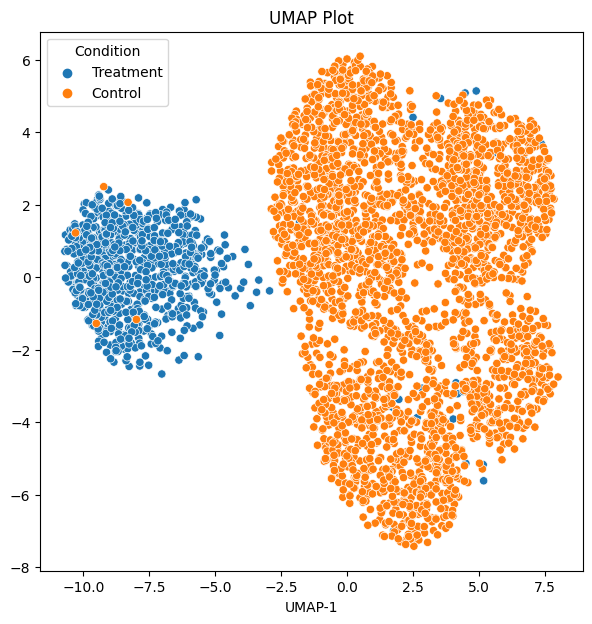

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

# Perform UMAP computation
sc.pp.neighbors(train_data)
sc.tl.umap(train_data)

# Store UMAP coordinates in the 'uns' attribute
train_data.uns['X_UMAP'] = train_data.obsm['X_UMAP']  # Use 'X_UMAP' instead of 'X_umap'

# Create a DataFrame with UMAP coordinates and other variables
umap_df = pd.DataFrame({
    'UMAP-1': train_data.uns['X_UMAP'][:, 0],
    'UMAP-2': train_data.uns['X_UMAP'][:, 1],
    'Cell Type': train_data.obs['label'],
    'Condition': train_data.obs['label']
})

# Create the UMAP plot
fig, ax = plt.subplots(figsize=[7, 7])
sns.scatterplot(data=umap_df, x='UMAP-1', y='UMAP-2', hue='Condition', ax=ax)

# Set the x-axis label
plt.xlabel('UMAP-1')

# Remove the y-axis label
plt.ylabel('')

# Set the plot title
plt.title('UMAP Plot')

# Display the plot
plt.show()


In [50]:
help(UnsupervisedDataset)

Help on class UnsupervisedDataset in module utils:

class UnsupervisedDataset(torch.utils.data.dataset.Dataset)
 |  UnsupervisedDataset(data, targets=None)
 |  
 |  Characterizes a dataset for PyTorch
 |  
 |  Method resolution order:
 |      UnsupervisedDataset
 |      torch.utils.data.dataset.Dataset
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |      Generates samples of data
 |  
 |  __init__(self, data, targets=None)
 |      Initialization
 |  
 |  __len__(self)
 |      Denotes the total number of samples
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {}
 |  
 |  __parameters__ = ()
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from torch.utils.data.dataset.Dataset:
 |  
 |  __add__(self, other: 'Dataset[T_co]') -> 'ConcatDataset[T_co]'
 |  
 |  -----------